In [1]:
import duckdb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.stats as sms

In [3]:
conn = duckdb.connect("../dataset/rumah.duckdb")

In [137]:
#conn.close()

In [94]:
def formatter_pvalue(x):
  return "color: red" if x < 0.05 else None

def formatter_one_zero(x):
  return "Tidak Ada" if x == 0 else "Ada"

## L1: Houses

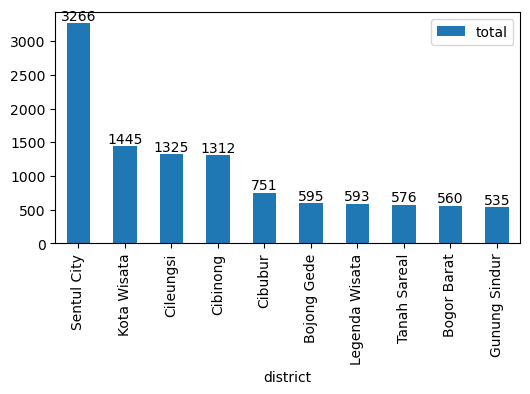

In [27]:
df_top10_district_listing = conn.sql("SELECT district, count(district) AS total FROM int_rumah123_houses GROUP BY district ORDER BY total DESC LIMIT 10").df().set_index("district")
ax = df_top10_district_listing.plot.bar(figsize=(6, 3))
ax.bar_label(ax.containers[0])
plt.show()

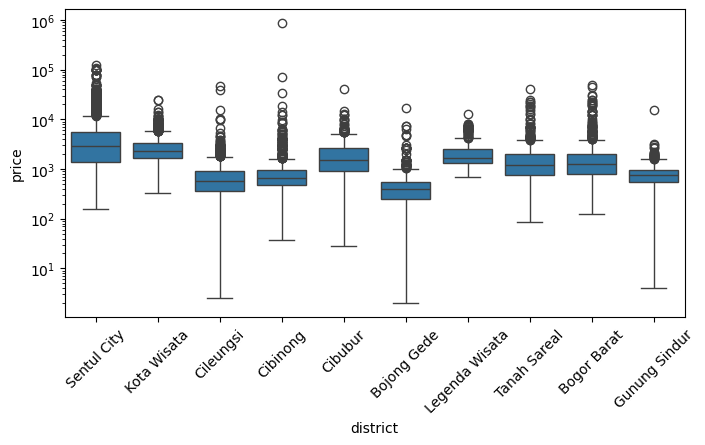

In [34]:
top10_districts = ','.join([f"'{col}'" for col in df_top10_district_listing.index])
df_district_price = conn.sql(f"SELECT district, price FROM int_rumah123_houses WHERE district IN ({top10_districts})").df()

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_district_price, x="district", y="price", order=df_top10_district_listing.index)
plt.xticks(rotation=45)
plt.yscale("log")
plt.show()

In [64]:
df_annual_house_listing = conn.sql("SELECT time_bucket(INTERVAL 1 MONTH, last_modified) AS ts, count(*) AS total FROM int_rumah123_houses GROUP BY ALL ORDER BY ts ASC").df()
df_annual_house_listing = df_annual_house_listing[df_annual_house_listing["ts"].dt.year == 2023]
df_annual_house_listing["cumulative"] = df_annual_house_listing["total"].cumsum()
df_annual_house_listing

,ts,total,cumulative
2,2023-01-01,3,3
3,2023-02-01,3,6
4,2023-03-01,10,16
5,2023-04-01,4,20
6,2023-05-01,4,24
7,2023-06-01,24,48
8,2023-07-01,383,431
9,2023-08-01,1178,1609
10,2023-09-01,1917,3526
11,2023-10-01,2581,6107


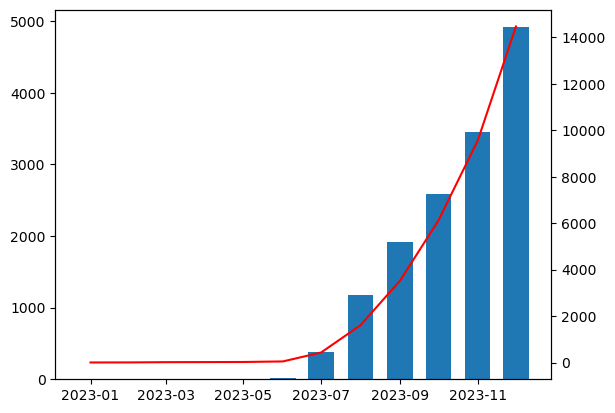

In [71]:
plt.bar(df_annual_house_listing["ts"], df_annual_house_listing["total"], width=20)
plt.twinx()
plt.plot(df_annual_house_listing["ts"], df_annual_house_listing["cumulative"], color="red")

In [76]:
conn.sql("SELECT district, avg(price) AS price_mean, median(price) AS price_median, stddev(price) AS price_std, count(price) AS price_count, min(price) AS price_min, max(price) AS price_max FROM int_rumah123_houses GROUP BY district ORDER BY price_mean DESC")

┌───────────────┬────────────────────┬──────────────┬────────────────────┬─────────────┬───────────┬───────────┐
│   district    │     price_mean     │ price_median │     price_std      │ price_count │ price_min │ price_max │
│    varchar    │       double       │    double    │       double       │    int64    │  double   │  double   │
├───────────────┼────────────────────┼──────────────┼────────────────────┼─────────────┼───────────┼───────────┤
│ Cimande       │            30750.0 │      38000.0 │ 14500.000000000002 │           4 │    9000.0 │   38000.0 │
│ Cijayanti     │ 24558.166666666668 │       2349.5 │   54149.0336032571 │           6 │     600.0 │  135000.0 │
│ Cibuluh       │            12313.0 │       1900.0 │   38133.1779894022 │          15 │     595.0 │  150000.0 │
│ Klapanunggal  │ 10938.214285714286 │        295.5 │ 45108.276291900744 │          28 │      58.0 │  239000.0 │
│ Harjasari     │ 10533.333333333334 │      12500.0 │  8130.395644329576 │           3 │    1600

### Outlier Analysis

In [81]:
def outlier_stats(dfo):
  total_data = dfo.shape[0]
  outliers_count = (dfo["is_outlier"] == True).sum()
  outliers_percent = outliers_count / total_data

  print("Total data:", total_data)
  print("Outliers count: {0:.2f} ({1:.2%})".format(outliers_count, outliers_percent))

In [82]:
def plot_dist(df, col):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

  sns.histplot(data=df, x=col, kde=True, ax=ax1)
  ax1.set_title("Distributions")

  sm.qqplot(df[col], line="s", ax=ax2)
  ax2.set_title("QQ Plot")

  fig.tight_layout()
  plt.show()

In [78]:
df_house_prices = conn.sql("SELECT price FROM int_rumah123_houses").df()
df_house_prices

,price
0,5300.0
1,8500.0
2,1200.0
3,4500.0
4,3190.0
...,...
20141,5000.0
20142,1650.0
20143,500.0
20144,2950.0


In [83]:
Q1 = df_house_prices['price'].quantile(0.25)
Q3 = df_house_prices['price'].quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
df_house_prices["is_outlier"] = (df_house_prices['price'] < Q1 - threshold * IQR) | (df_house_prices['price'] > Q3 + threshold * IQR)

print(outlier_stats(df_house_prices))
df_house_prices.head(2)

Total data: 20146
Outliers count: 1901.00 (9.44%)
None


,price,is_outlier
0,5300.0,False
1,8500.0,True


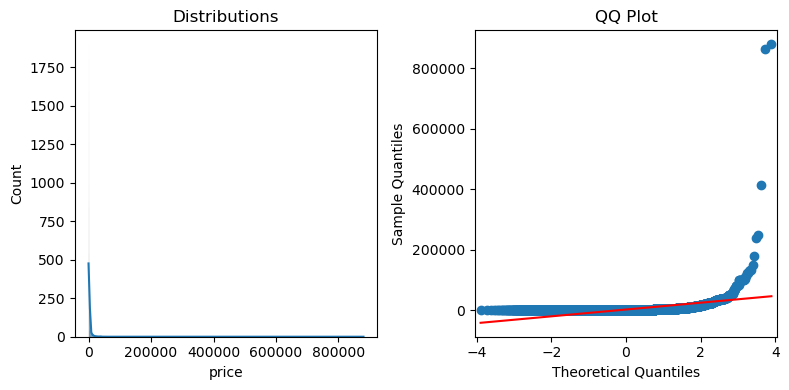

In [85]:
plot_dist(df_house_prices, "price")

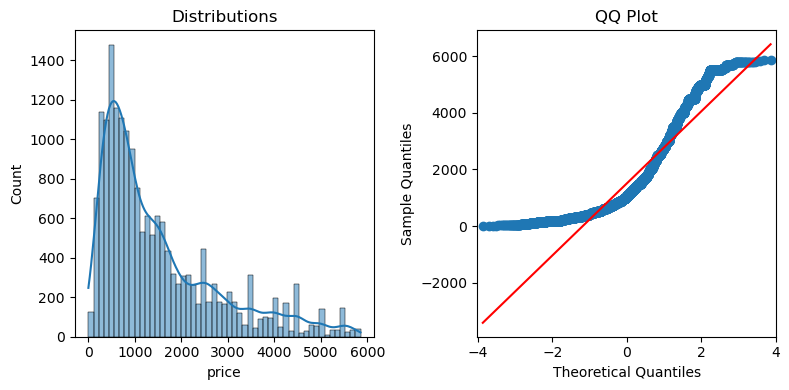

In [86]:
df_oulier_iqr_vis = df_house_prices[df_house_prices["is_outlier"] == False]
plot_dist(df_oulier_iqr_vis, "price")

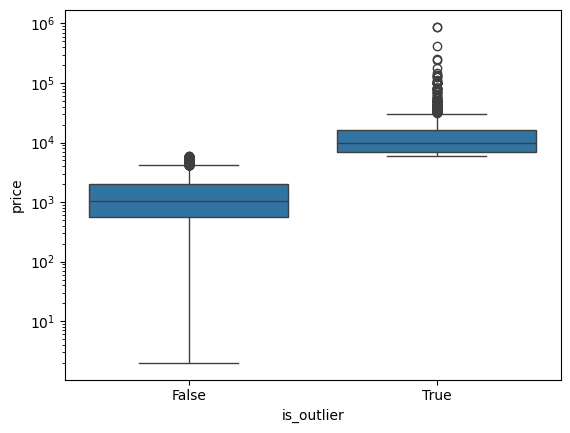

In [87]:
sns.boxplot(data=df_house_prices, y="price", x="is_outlier")
plt.yscale("log")

## L1: Tags

In [100]:
df_tags = conn.sql(f"SELECT h.district, h.city, h.price, t.* FROM int_rumah123_tags t LEFT JOIN int_rumah123_houses h ON t.reference_id = h.id").df()
df_tags.head()

,district,city,price,reference_id,tag_bisa_nego,tag_cash_keras,tag_komplek,tag_perumahan,tag_kpr,tag_one_gate_system,tag_cash_bertahap,tag_dijual_cepat,tag_pinggir_jalan,tag_pedesaan,tag_masuk_gang
0,Sentul City,Bogor,5300.0,hos16067945,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,Sentul City,Bogor,8500.0,hos15793696,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Sentul City,Bogor,6500.0,hos15634577,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Jonggol,Bogor,380.0,hos12705193,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sentul City,Bogor,850.0,hos15767028,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


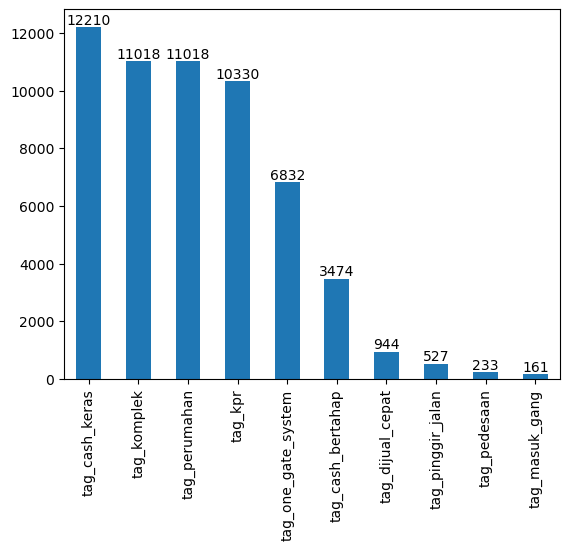

In [103]:
tags_ax = df_tags.iloc[:, 5:].sum().sort_values(ascending=False).plot.bar()
tags_ax.bar_label(tags_ax.containers[0])
plt.show()

In [106]:
piv_tags = df_tags.pivot_table(index="district", columns="tag_bisa_nego", values="price", aggfunc=["mean", "median", "count"], fill_value=0)
piv_tags.head(10).sort_values(("mean", 0), ascending=False).round(2)

mean             median          count     
tag_bisa_nego        0.0       1.0      0.0      1.0   0.0  1.0
district                                                       
Batutulis       12033.33   4784.44  15000.0   1600.0     3    9
Babakan          9500.62  10396.30   8945.0   8000.0    16   23
Baranangsiang    6277.00   6369.34   5950.0   4500.0    14   83
Babakan Madang   4649.31   4350.69   1685.0   1900.0    26   58
Bantar Jati      3084.93   2062.07   1750.0   1825.0    14   46
Ahmadyani        2950.00  10200.00   4000.0  10200.0     3    2
Bogor Barat      1778.68   2695.02    890.0   1300.0   122  375
Balumbang Jaya    850.00   1883.33    850.0    900.0     1    3
Ardio             500.00    715.00    500.0    715.0     1    2
Babakan Pasar       0.00  13500.00      0.0   5000.0     0    3

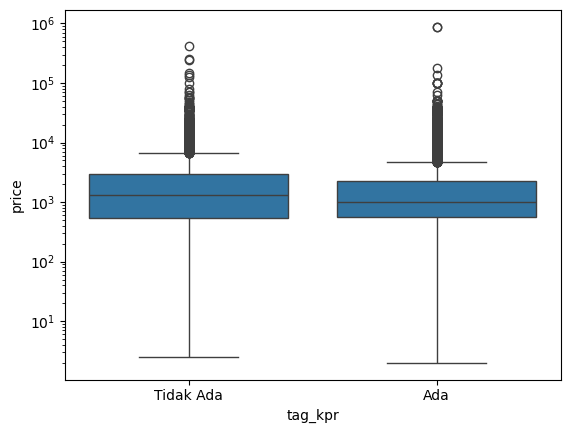

In [107]:
sns.boxplot(data=df_tags, x="tag_kpr", y="price", formatter=formatter_one_zero)
plt.yscale("log")

## L1: Facilities

In [108]:
df_tags = conn.sql(f"SELECT h.district, h.city, h.price, t.* FROM int_rumah123_facilities t LEFT JOIN int_rumah123_houses h ON t.reference_id = h.id").df()
df_tags.head()

,district,city,price,reference_id,facility_keamanan,facility_ac,facility_lapangan,facility_taman,facility_laundry,facility_masjid,...,facility_gas,facility_heating,facility_musholla,facility_floorboards,facility_shed,facility_aula,facility_canopy,facility_lemari_sepatu,facility_mezzanine,facility_lemari_pakaian
0,Cilebut,Bogor,200.0,hos14532687,2.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cileungsi,Bogor,181.0,hos14597379,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Parung Panjang,Bogor,1000.0,hos14597939,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cibinong,Bogor,381.0,hos14478030,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cilebut,Bogor,275.0,hos14423820,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


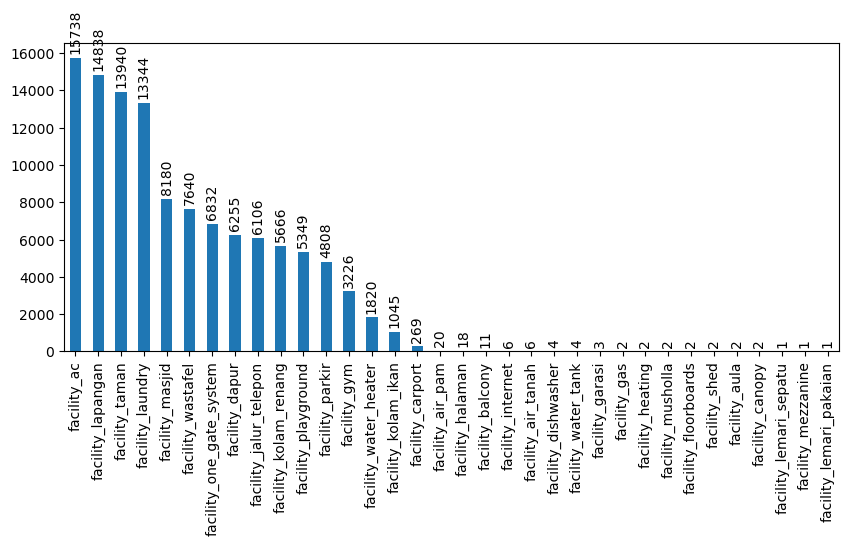

In [109]:
plt.figure(figsize=(10, 4))
ax = df_tags.iloc[:, 5:].sum().plot.bar()
ax.bar_label(ax.containers[0])
plt.show()

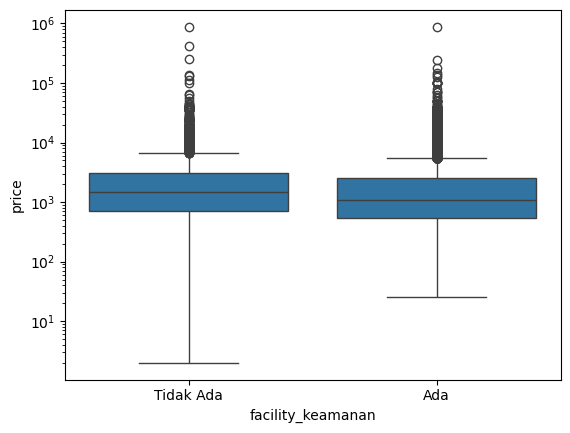

In [110]:
fac_price_ax = sns.boxplot(data=df_tags, x="facility_keamanan", y="price", formatter=formatter_one_zero)
plt.yscale("log")

## L1: House Material

In [116]:
df_house_materials = conn.sql(f"SELECT h.district, h.city, h.price, t.* FROM int_rumah123_house_materials t LEFT JOIN int_rumah123_houses h ON t.reference_id = h.id").df()
df_house_materials.head()

,district,city,price,reference_id,house_mat_bata_hebel,house_mat_bata_merah,house_mat_beton,house_mat_batako
0,Sentul City,Bogor,5300.0,hos16067945,0.0,1.0,0.0,0.0
1,Parung Panjang,Bogor,1200.0,hos14911515,0.0,0.0,1.0,0.0
2,Sentul City,Bogor,3190.0,hos14264153,0.0,1.0,1.0,0.0
3,Sentul City,Bogor,6500.0,hos15634577,0.0,1.0,0.0,0.0
4,Jonggol,Bogor,380.0,hos12705193,1.0,0.0,0.0,0.0


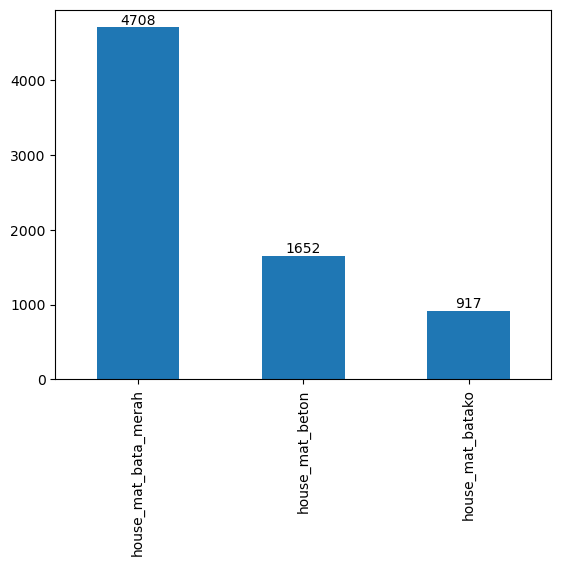

In [117]:
ax = df_house_materials.iloc[:, 5:].sum().sort_values(ascending=False).plot.bar()
ax.bar_label(ax.containers[0])
plt.show()

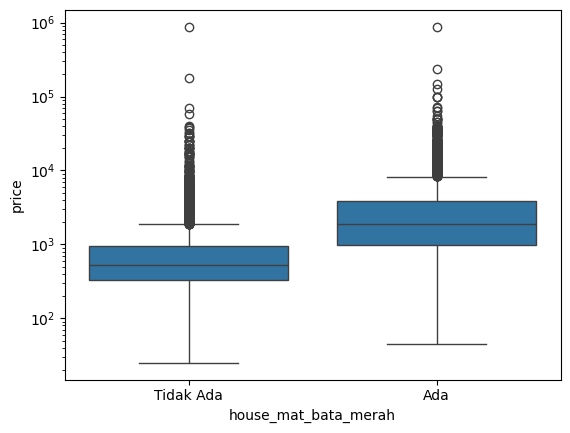

In [119]:
sns.boxplot(data=df_house_materials, x="house_mat_bata_merah", y="price", formatter=formatter_one_zero)
plt.yscale("log")

## L1: Floor Material

In [120]:
df_floor_materials = conn.sql(f"SELECT h.district, h.city, h.price, t.* FROM int_rumah123_floor_materials t LEFT JOIN int_rumah123_houses h ON t.reference_id = h.id").df()
df_floor_materials.head()

,district,city,price,reference_id,floor_mat_granit,floor_mat_keramik,floor_mat_ubin,floor_mat_marmer,floor_mat_vinyl
0,Sentul City,Bogor,5300.0,hos16067945,1.0,1.0,0.0,0.0,0.0
1,Parung Panjang,Bogor,1200.0,hos14911515,0.0,1.0,0.0,0.0,0.0
2,Sentul City,Bogor,3190.0,hos14264153,0.0,1.0,1.0,0.0,0.0
3,Sentul City,Bogor,6500.0,hos15634577,1.0,0.0,0.0,0.0,0.0
4,Jonggol,Bogor,380.0,hos12705193,1.0,0.0,0.0,0.0,0.0


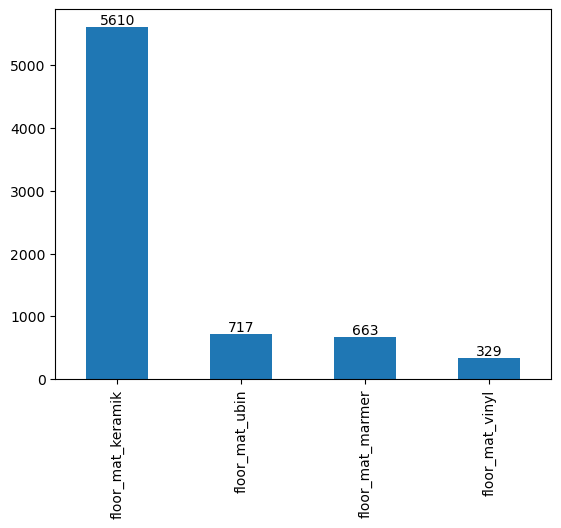

In [124]:
ax = df_floor_materials.iloc[:, 5:].sum().sort_values(ascending=False).plot.bar()
ax.bar_label(ax.containers[0])
plt.show()

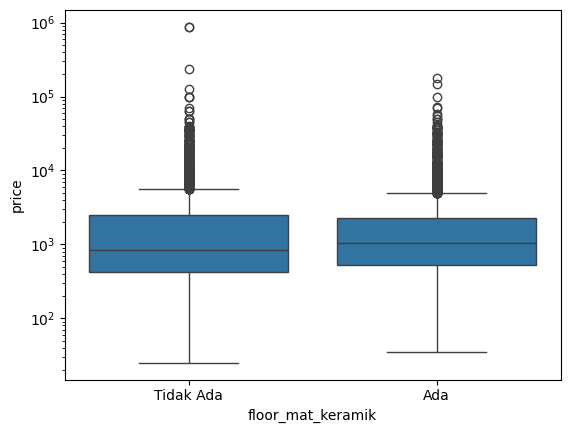

In [125]:
price_ax = sns.boxplot(data=df_floor_materials, x="floor_mat_keramik", y="price", formatter=formatter_one_zero)
plt.yscale("log")

## L1: Specs

In [126]:
df_specs = conn.sql(f"SELECT h.district, h.city, h.price, t.* FROM int_rumah123_specs t LEFT JOIN int_rumah123_houses h ON t.reference_id = h.id").df()
df_specs.head()

,district,city,price,reference_id,kamar_tidur,kamar_mandi,kamar_pembantu,kamar_mandi_pembantu,dapur,luas_tanah,...,sumber_air,pemandangan,tipe_properti,konsep_dan_gaya_rumah,kondisi_properti,kondisi_perabotan,hook,ruang_tamu,ruang_makan,terjangkau_internet
0,Sentul City,Bogor,5300.0,hos16067945,4,4,1,1,2,251.0,...,PAM atau PDAM,Pegunungan,Rumah,American Classic,furnished,unfurnished,1,1,1,1
1,Sentul City,Bogor,8500.0,hos15793696,4,3,2,1,2,381.0,...,PAM atau PDAM,Pegunungan,Rumah,American Classic,furnished,furnished,0,1,1,1
2,Sentul City,Bogor,4500.0,hos15746906,3,3,3,1,1,265.0,...,PAM atau PDAM,Pemukiman Warga,Rumah,Modern,furnished,unfurnished,0,1,1,1
3,Sentul City,Bogor,6500.0,hos15634577,4,5,2,1,1,313.0,...,PAM atau PDAM,Pemukiman Warga,Rumah,American Classic,furnished,unfurnished,0,1,1,1
4,Jonggol,Bogor,380.0,hos12705193,2,2,0,0,1,72.0,...,PAM atau PDAM,Pemukiman Warga,Rumah,Minimalis,furnished,unfurnished,0,1,1,1


In [129]:
df_specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20146 entries, 0 to 20145
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district               20146 non-null  object 
 1   city                   20146 non-null  object 
 2   price                  20146 non-null  float64
 3   reference_id           20146 non-null  object 
 4   kamar_tidur            20146 non-null  int32  
 5   kamar_mandi            20146 non-null  int32  
 6   kamar_pembantu         20146 non-null  int32  
 7   kamar_mandi_pembantu   20146 non-null  int32  
 8   dapur                  20146 non-null  int32  
 9   luas_tanah             20146 non-null  float32
 10  luas_bangunan          20146 non-null  float32
 11  jumlah_lantai          20146 non-null  int32  
 12  garasi                 20146 non-null  int32  
 13  carport                20146 non-null  int32  
 14  lebar_jalan            20146 non-null  float32
 15  ta

In [128]:
df_specs["sertifikat"].value_counts()

sertifikat
SHM - Sertifikat Hak Milik    16294
HGB - Hak Guna Bangunan        2873
Lainnya                         968
HP - Hak Pakai                   11
Name: count, dtype: int64

In [130]:
df_specs["hadap"].value_counts()

hadap
Timur         15253
Selatan        1898
Utara          1285
Barat           894
Barat Daya      261
Timur Laut      236
Tenggara        185
Barat Laut      134
Name: count, dtype: int64

In [131]:
df_specs["sumber_air"].value_counts()

sumber_air
PAM atau PDAM    15313
Sumur Bor         3523
Sumur Pompa       1182
Sumur Resapan       81
Sumur Galian        47
Name: count, dtype: int64

In [133]:
df_specs["konsep_dan_gaya_rumah"].value_counts()

konsep_dan_gaya_rumah
Minimalis Modern      14044
Modern                 2199
Minimalis              1906
Scandinavian            782
American Classic        467
Modern Glass House      224
Kontemporer             203
Town House              162
Paviliun                 90
Industrial               69
Name: count, dtype: int64

In [134]:
df_specs["kondisi_properti"].value_counts()

kondisi_properti
furnished         16836
unfurnished        3270
semi furnished       40
Name: count, dtype: int64

In [135]:
df_specs["kondisi_perabotan"].value_counts()

kondisi_perabotan
unfurnished       16121
semi furnished     2540
furnished          1485
Name: count, dtype: int64

In [136]:
with pd.option_context('display.float_format', '{:.4f}'.format):
  display(sms.descriptivestats.describe(df_specs))

,price,kamar_tidur,kamar_mandi,kamar_pembantu,kamar_mandi_pembantu,dapur,luas_tanah,luas_bangunan,jumlah_lantai,garasi,carport,lebar_jalan,tahun_dibangun,tahun_di_renovasi,daya_listrik,hook,ruang_tamu,ruang_makan,terjangkau_internet
nobs,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000,20146.0000
missing,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
mean,2887.2228,3.2257,2.4151,0.3462,0.2752,1.0516,398.0447,186.2134,1.4608,0.7826,1.0101,1.2807,826.4897,367.7989,2434.6172,0.1275,0.7332,0.5231,0.6346
std_err,79.4901,0.0389,0.0387,0.0042,0.0034,0.0023,21.0690,3.5873,0.0041,0.1547,0.0109,0.0078,7.1149,6.0460,18.2310,0.0024,0.0031,0.0035,0.0034
upper_ci,3043.0206,3.3019,2.4909,0.3545,0.2820,1.0561,439.3391,193.2443,1.4688,1.0857,1.0315,1.2960,840.4346,379.6488,2470.3493,0.1321,0.7394,0.5300,0.6413
lower_ci,2731.4251,3.1495,2.3392,0.3379,0.2684,1.0470,356.7503,179.1824,1.4527,0.4795,0.9888,1.2653,812.5447,355.9489,2398.8851,0.1229,0.7271,0.5162,0.6280
std,11282.5562,5.5185,5.4938,0.6012,0.4896,0.3280,2990.4583,509.1646,0.5835,21.9520,1.5473,1.1118,1009.8642,858.1495,2587.6475,0.3336,0.4423,0.4995,0.4815
iqr,2100.0000,2.0000,2.0000,1.0000,1.0000,0.0000,168.0000,148.0000,1.0000,1.0000,1.0000,2.0000,2019.0000,0.0000,900.0000,0.0000,1.0000,1.0000,1.0000
iqr_normal,1556.7323,1.4826,1.4826,0.7413,0.7413,0.0000,124.5386,109.7126,0.7413,0.7413,0.7413,1.4826,1496.6869,0.0000,667.1710,0.0000,0.7413,0.7413,0.7413
mad,2808.1833,1.2161,1.2752,0.4902,0.4085,0.0983,456.1674,150.0598,0.5263,1.0428,0.7300,1.0188,976.8274,604.0332,1279.2189,0.2225,0.3912,0.4989,0.4638
